In [167]:
import numpy as np
import pandas as pd

In [168]:
language_phonemes = np.load("./data/language_phonemes.npy", allow_pickle=True).astype(int)
language_names = np.load("./data/language_names.npy", allow_pickle=True)[:, 0]

assert language_phonemes.shape[0] == language_names.shape[0]
language_names.shape, language_phonemes.shape

((2949,), (2949, 24, 22))

For languages that have multiple samples in the Phoible dataset, we need to select a way of choosing one sample or combine multiple samples into one.

In [169]:
unique_names, unique_names_count = np.unique(language_names, return_counts=True)
multiple_samples = unique_names[unique_names_count > 1]
single_sample = unique_names[unique_names_count == 1]

language_data = {
    name: {"data": language_phonemes[language_names == name]} for name in unique_names
}

# sense check
for name in unique_names:
    assert (
        language_phonemes[language_names == name].shape
        == language_data[name]["data"].shape
    )

In [170]:
all_values = np.sort(np.unique(language_phonemes))
# all_values = all_values[all_values > 0]

for name, v in language_data.items():
    if name in multiple_samples:
        v["min"] = np.min(v["data"], axis=0)
        v["max"] = np.max(v["data"], axis=0)
        v["mean"] = np.rint(np.mean(v["data"], axis=0))
        v["diff"] = v["max"] - v["min"]
    else:
        v["min"] = v["data"][0]
        v["max"] = v["data"][0]
        v["mean"] = v["data"][0]
        v["diff"] = np.zeros(v["data"][0].shape)

    min, min_counts = np.unique(v["min"], return_counts=True)
    max, max_counts = np.unique(v["max"], return_counts=True)

    counts = [
        *[0 if n not in min else min_counts[np.where(min == n)][0] for n in all_values],
        *[0 if n not in max else max_counts[np.where(max == n)][0] for n in all_values],
    ]
    v["counts"] = np.array(counts)

# sense check
assert all(
    [
        metric.shape == language_phonemes.shape[1:]
        for k, v in language_data.items()
        for n, metric in v.items()
        if n != "data" and n != "counts"
    ]
)

In [171]:
lang_stats = np.array(
    [
        [name, v["min"].sum(), v["max"].sum(), v["mean"].sum(), v["diff"].sum()]
        for name, v in language_data.items()
        if name in multiple_samples
    ]
)

lang_stats_df = pd.DataFrame(
    lang_stats[:, 1:], index=lang_stats[:, 0], columns=["min", "max", "mean", "diff"]
).sort_values("diff", ascending=False)
lang_stats_df.head(5)

,min,max,mean,diff
Remo,141,229,188.0,88
Iron Ossetic,132,220,150.0,88
Laz,135,222,153.0,87
Lithuanian,136,219,166.0,83
Spanish,135,216,155.0,81


The table above shows a huge difference between max/min values in each sample.

The values shown are sums of all the values in the language_phoneme matrix for each language.

In [172]:
phoneme_type_counts = np.array(
    [v["counts"] for name, v in language_data.items() if name in multiple_samples]
)

phoneme_type_counts_df = pd.DataFrame(
    phoneme_type_counts,
    index=lang_stats[:, 0],
    columns=[f"{v}_min" for v in all_values] + [f"{v}_max" for v in all_values],
).sort_values("3_max", ascending=False)
phoneme_type_counts_df.head(10)

,0_min,1_min,2_min,3_min,0_max,1_max,2_max,3_max
Shan,479,5,0,44,439,11,1,77
Remo,475,9,0,44,443,13,0,72
Mingrelian,475,9,0,44,431,24,2,71
Lithuanian,480,4,0,44,443,18,0,67
English (British),469,15,0,44,453,7,1,67
Kabardian,479,5,0,44,441,22,0,65
Greek,469,15,0,44,440,24,1,63
Western Balochi,477,7,0,44,444,22,0,62
Friulian,478,6,0,44,455,11,0,62
Spanish,481,3,0,44,430,38,2,58


It seems most of the difference can be explained by some datasets including information on phoneme length. In the language_phoneme matrix, a bitmaks-like encoding was used. 

- 0 = phoneme not present
- 1 = phoneme present (regular length)
- 2 = phoneme present (long length)
- 3 = phoneme present (regular & long length)

In the 10 examples above, the `min` sample doesn't contain long phonemes, while the `max` sample does.

Based on that knowledge, it probably makes sense to use the `max` sample for each language. It probably contains the most phonemes for the language and also encodes more information about each phoneme than samples lacking any data on phoneme length.

Adding an extra dimension (3d to 4d) would make it possible to use `Conv2D` layers as in image processing. 

In [173]:
language_phonemes_selected = np.expand_dims(
    np.array(
        [
            np.max(language_phonemes[language_names == name], axis=0)
            for name in unique_names
        ]
    ),
    axis=-1,
) / np.max(language_phonemes)
language_phonemes_selected.shape

(2740, 24, 22, 1)

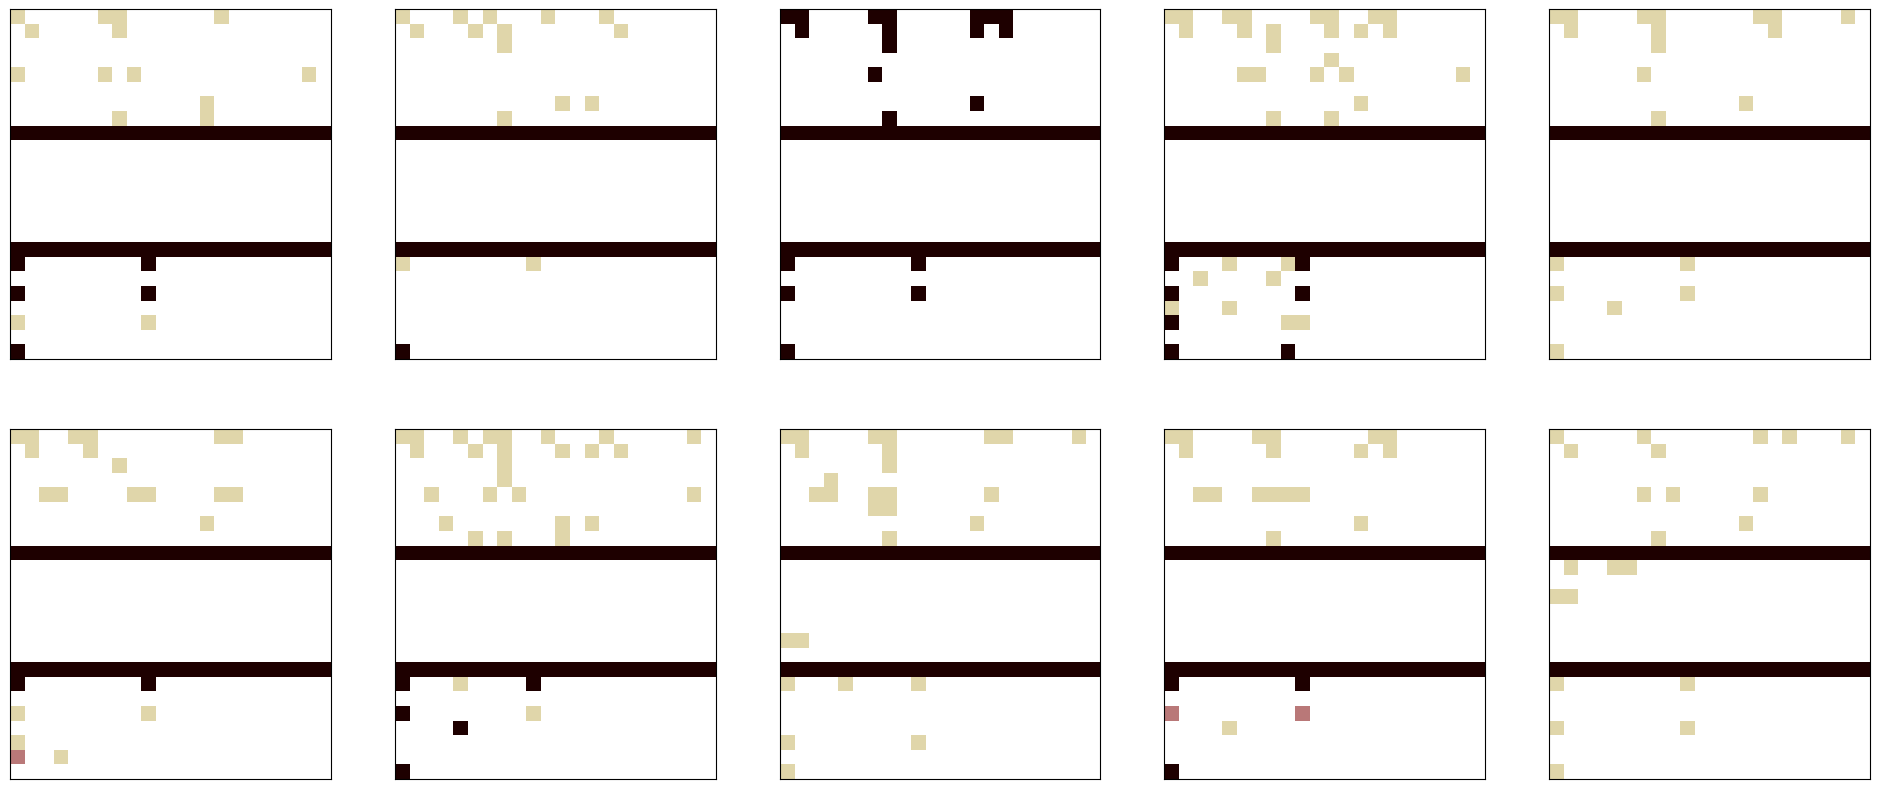

In [175]:
import matplotlib.pyplot as plt

r, c = 2, 5

gen = np.random.default_rng()
samples = gen.choice(language_phonemes_selected, r * c, replace=False)

fig, axs = plt.subplots(r, c, figsize=(24, 10), linewidth=10)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(
            samples[cnt],
            cmap=plt.get_cmap("pink_r"),
            vmin=np.min(language_phonemes_selected),
            vmax=np.max(language_phonemes_selected),
        )
        axs[i, j].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        cnt += 1

plt.show()

In [176]:
np.save("./data/language_phonemes_selected.npy", language_phonemes_selected)